# Transcriptional drift of Gene Ontology groupings (full transcriptome)

Tong Shu Li

Initial exploration of transcriptional drift of genes grouped by Gene Ontology annotations.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from collections import defaultdict
from functools import partial

In [2]:
%matplotlib inline

In [3]:
sys.path.append("..")

In [4]:
from src.plots import plot_drift
from src.plots import plot_p_val_heatmap

from src.stats import p_val_pairs

from src.gene_ont import load_annotations
from src.gene_ont import parse_go_defn
from src.gene_ont import parse_go_links
from src.gene_ont import group_genes
from src.gene_ont import filter_go

---

## Read the data (full transcriptome)

In [5]:
data = pd.read_csv("../data/worms_mianserin/mean_cpm_values.tsv", sep = '\t')

In [6]:
data.shape

(230028, 12)

In [7]:
data.head()

,wormbaseid,symbol,seqname,cpm_val,sample,day_add_drug,day_harvest_rna,drug_conc_uM,drug_given,log_cpm,ref_log_cpm,drift
0,WBGene00022521,ZC132.2,ZC132.2,0.000226,1,1,1,0,water,-8.393649,-8.393649,0.0
1,WBGene00019835,R02F2.6,R02F2.6,0.000228,1,1,1,0,water,-8.386604,-8.386604,0.0
2,WBGene00006011,srx-120,F49C5.2,0.000262,1,1,1,0,water,-8.247548,-8.247548,0.0
3,WBGene00022884,ZK1248.17,ZK1248.17,0.000275,1,1,1,0,water,-8.199831,-8.199831,0.0
4,WBGene00005435,srh-227,C35D6.2,0.000298,1,1,1,0,water,-8.116741,-8.116741,0.0


## Read the wormbase GO annotations

In [8]:
floc = "../data/gene_ontology/gene_association.wb"
go_data = load_annotations(floc)

In [9]:
go_data.head()

,database_id,db_obj_symbol,qualifier,go_id,db_ref,evidence,with_from,aspect,db_obj_name,db_obj_syn,db_obj_type,taxon,date,assigned_by,annot_ext,gene_prod_id
0,WBGene00000001,aap-1,NaN,GO:0005623,WB_REF:WBPaper00005614|PMID:12393910,IDA,NaN,C,NaN,Y110A7A.10,gene,taxon:6239,20060302,WB,NaN,NaN
1,WBGene00000001,aap-1,NaN,GO:0005942,GO_REF:0000033,IBA,PANTHER:PTN000806614,C,NaN,Y110A7A.10,gene,taxon:6239,20150227,GO_Central,NaN,NaN
2,WBGene00000001,aap-1,NaN,GO:0005942,GO_REF:0000002,IEA,InterPro:IPR001720,C,NaN,Y110A7A.10,gene,taxon:6239,20150826,WB,NaN,NaN
3,WBGene00000001,aap-1,NaN,GO:0008286,WB_REF:WBPaper00005614|PMID:12393910,IMP,NaN,P,NaN,Y110A7A.10,gene,taxon:6239,20060302,WB,NaN,NaN
4,WBGene00000001,aap-1,NaN,GO:0008340,WB_REF:WBPaper00005614|PMID:12393910,IMP,NaN,P,NaN,Y110A7A.10,gene,taxon:6239,20060302,WB,NaN,NaN


### GO term definitions

In [10]:
go_defn = parse_go_defn("../data/gene_ontology/go.obo")

In [11]:
go_defn.head()

,go_id,go_name,namespace,obsolete
0,GO:0000001,mitochondrion inheritance,biological_process,False
1,GO:0000002,mitochondrial genome maintenance,biological_process,False
2,GO:0000003,reproduction,biological_process,False
3,GO:0000005,obsolete ribosomal chaperone activity,molecular_function,True
4,GO:0000006,high-affinity zinc uptake transmembrane transp...,molecular_function,False


In [12]:
go_data["go_id"].nunique()

5123

In [13]:
go_defn["go_id"].nunique()

44471

In [14]:
go_data["database_id"].nunique()

12524

In [15]:
len(set(data["wormbaseid"]) & set(go_data["database_id"]))

11624

## Parse the GO hierarchy

In [16]:
fname = "../data/gene_ontology/go.obo"
children = parse_go_links(fname)

---

## Genes annotated with each term

In [17]:
# save the gene names for each GO term
annots = defaultdict(
    set,
    {
        go_term: set(df["database_id"])
        for go_term, df in go_data.groupby("go_id")
    }
)

## Genes associated with each GO term (considering hierarchy)

In [18]:
go_groups = group_genes(children, annots, ["is_a", "part_of"])

---

# Hypothesis testing

In [19]:
info = pd.DataFrame(
    [(go_term, len(genes)) for go_term, genes in go_groups.items()],
    columns = ["go_id", "num_genes"]
)

info = pd.merge(info, go_defn, how = "inner", on = "go_id")

In [20]:
info.shape

(42514, 5)

In [21]:
info.head()

,go_id,num_genes,go_name,namespace,obsolete
0,GO:0009306,27,protein secretion,biological_process,False
1,GO:0008870,0,galactoside O-acetyltransferase activity,molecular_function,False
2,GO:0043334,0,"2-hexaprenyl-6-methoxy-1,4-benzoquinone methyl...",molecular_function,False
3,GO:0090263,0,positive regulation of canonical Wnt signaling...,biological_process,False
4,GO:0052199,0,negative regulation of catalytic activity in o...,biological_process,False


In [22]:
all(~info["obsolete"])

True

In [23]:
(info["num_genes"] == 0).sum()

34472

In [24]:
info = info.query("num_genes > 0")

In [25]:
good_genes = set(data["wormbaseid"])

info["num_in_data"] = info["go_id"].map(
    lambda v: len(good_genes & go_groups[v])
)

info = info.sort_values("num_in_data", ascending = False).reset_index(drop = True)
info["frac_present"] = info["num_in_data"] / info["num_genes"]

In [26]:
info.shape

(8042, 7)

In [27]:
info.head()

,go_id,num_genes,go_name,namespace,obsolete,num_in_data,frac_present
0,GO:0008150,11336,biological_process,biological_process,False,10477,0.924224
1,GO:0003674,8944,molecular_function,molecular_function,False,8663,0.968582
2,GO:0044699,8576,single-organism process,biological_process,False,7984,0.930970
3,GO:0005575,7895,cellular_component,cellular_component,False,7617,0.964788
4,GO:0009987,7233,cellular process,biological_process,False,6870,0.949813


In [28]:
(info["num_in_data"] >= 10).sum()

2689

By considering the GO hierarchy, we now have 2689 GO terms with >= 10 genes in our dataset, instead of the original 897.

In [29]:
info = info.query("num_in_data >= 10")

---

## Significance checking function

In [30]:
def signif(go_term, df, go_groups, groupby, drift_col, conditions):
    """Check for significant drift.
    
    For a subset of genes specified by the GO term, calculates the
    p-values when grouped together by the groupby. Then checks that
    all p values of the condition pairs are below the significance
    threshold.
    
    Conditions = dict(key: direction)
    where key = pair of groups, direction = boolean of whether the variance
    of the left group is larger
    """
    res = filter_go([go_term], go_groups, df, "wormbaseid")
    
    p_vals = p_val_pairs(res, groupby, drift_col)
    
    threshold = 0.05
    for pair in conditions:
        assert pair in p_vals, "{} not in p-val pairs".format(pair)
        
    return all(
        p_vals[i][0] < threshold and p_vals[i][1] == direction
        for i, direction in conditions.items()
    )

## Drift in water

Drift in water on day 10 is greater than drift on day 3.

In [31]:
water = data.query("drug_given == 'water' & day_harvest_rna > 1")

water_310 = partial(
    signif, df = water, go_groups = go_groups, groupby = "day_harvest_rna",
    drift_col = "drift",
    conditions = {(3, 10): False}
)

In [32]:
info["water_310"] = info["go_id"].map(water_310)

In [33]:
info["water_310"].value_counts()

False    1947
True      742
Name: water_310, dtype: int64

---

## Drift on day 10: reduced in mianserin compared to water

In [34]:
mian_10 = partial(
    signif,
    df = data.query("day_add_drug == 1 & drug_conc_uM in(0, 50)"),
    go_groups = go_groups, groupby = ["drug_given", "day_harvest_rna"],
    drift_col = "drift",
    conditions = {
        (('mianserin', 10), ('water', 10)): False
    }
)

In [35]:
info["mian_water_10"] = info["go_id"].map(mian_10)

In [36]:
info["mian_water_10"].value_counts()

False    1687
True     1002
Name: mian_water_10, dtype: int64

## Results

In [37]:
info.groupby(["water_310", "mian_water_10"]).size()

water_310  mian_water_10
False      False            1561
           True              386
True       False             126
           True              616
dtype: int64

In the full transcriptome, 616 GO terms (with >= 10 genes) had significant drift:
1. Greater drift on day 10 in water compared to day 3.
2. Smaller drift on day 10 in mianserin compared to water.

## Check results:

In [38]:
info.query("water_310 & mian_water_10")

,go_id,num_genes,go_name,namespace,obsolete,num_in_data,frac_present,water_310,mian_water_10
0,GO:0008150,11336,biological_process,biological_process,False,10477,0.924224,True,True
1,GO:0003674,8944,molecular_function,molecular_function,False,8663,0.968582,True,True
2,GO:0044699,8576,single-organism process,biological_process,False,7984,0.930970,True,True
3,GO:0005575,7895,cellular_component,cellular_component,False,7617,0.964788,True,True
4,GO:0009987,7233,cellular process,biological_process,False,6870,0.949813,True,True
5,GO:0005623,6200,cell,cellular_component,False,6003,0.968226,True,True
6,GO:0044464,6148,cell part,cellular_component,False,5955,0.968608,True,True
7,GO:0044763,5737,single-organism cellular process,biological_process,False,5405,0.942130,True,True
8,GO:0008152,5332,metabolic process,biological_process,False,5230,0.980870,True,True
9,GO:0032501,5547,multicellular organismal process,biological_process,False,5090,0.917613,True,True


## Check out one example:

## Syntaxin binding (GO:0019905)

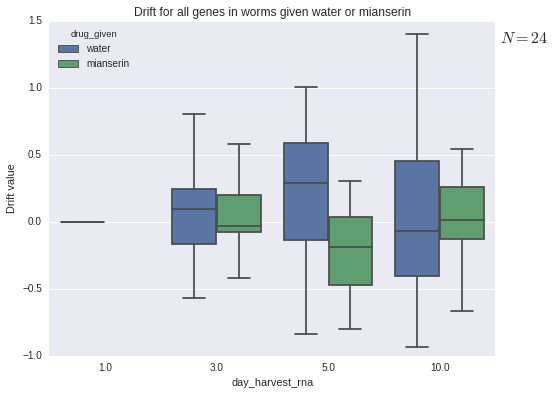

In [39]:
temp = data.query("day_add_drug == 1 & drug_conc_uM in(0, 50)")

term = "GO:0019905"

res = filter_go([term], go_groups, temp, "wormbaseid")
plot_drift(
    "box", res, "day_harvest_rna", "drift", "seqname",
    groupby = "drug_given", rc = {"figure.figsize": (8, 6)},
    title = "Drift for all genes in worms given water or mianserin"
);

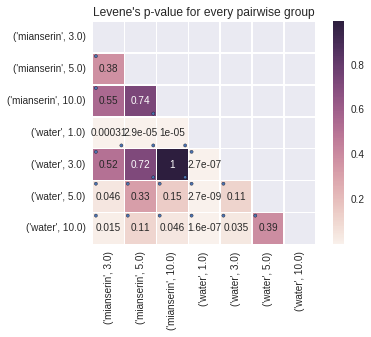

In [40]:
plot_p_val_heatmap(res, ["drug_given", "day_harvest_rna"], "drift", circles = True);

We see that for this GO term, the genes drifted apart in water as time went on, but that when given mianserin, the genes do not drift apart. They are lower than water, but do not drift apart compared to one another.